# 近邻成分分析（Neighborhood Component Analysis）


------------------

## 理论分析
### 模型（1）和模型（2）分别提出于NIPS 2005和NIPS 2006的两篇论文：

#### 模型（1）
*来自论文：Jacob Goldberger, Sam Roweis, Geoff Hinton, Ruslan Salakhutdinov. "Neighbourhood components analysis." NIPS 2005.*  

这篇论文是度量学习的经典论文。度量学习说白了就是对样本进行距离度量进而分类。这篇工作针对最基础的KNN（最近邻）方法的两大不足：  
&nbsp;&nbsp;&nbsp;&nbsp;1.存储和计算开销（样本多，维度高）  
&nbsp;&nbsp;&nbsp;&nbsp;2.距离到底如何度量（near是怎么定义的）  
本篇工作提出了解决方案：学习一个线性变换（就是我们这里的$P$）将特征从初始特征空间投影到一个新的特征空间（低维度的，也即特征降维），然后再在新的特征空间中进行欧氏距离分类，其实这里**相当于做了一个基于矩阵$M=PP^T$的马氏距离**，因为$d(x, y)=(x-y)^{\top} M(x-y)=(P x-P y)^{\top}(P x-P y)$。  
那么问题来了，这个线性变换要怎么学？作者提出，首先可以用距离$d(x_i, x_j)$的softmax形式来建模$x_i$和$x_j$属于同一类的概率：  
$$p_{i j}=\frac{\exp \left(-\left\|P x_{i}-P x_{j}\right\|^{2}\right)}{\sum_{k \neq i} \exp \left(-\left\|P x_{i}-P x_{k}\right\|^{2}\right)} \quad, \quad p_{i i}=0$$  
那么$x_i$能被正确分类的概率正比于：
$$p_{i}=\sum_{j \in C_{i}} p_{i j}$$
于是我们要优化的函数就是，最大化（当然损失函数就是最小化该负数即可）：
$$f(P)=\sum_{i} \sum_{j \in C_{i}} p_{i j}=\sum_{i} p_{i}$$  
由于要用到梯度下降，故求出梯度形式：
$$\frac{\partial f}{\partial P}=2 P \sum_{i}\left(p_{i} \sum_{k} p_{i k} x_{i k} x_{i k}^{\top}-\sum_{j \in C_{i}} p_{i j} x_{i j} x_{i j}^{\top}\right)$$  



#### 模型（2）
*来自论文：Kilian Q. Weinberger, John Blitzer and Lawrence K. Saul. "Distance metric learning for large margin nearest neighbor classification." NIPS 2006.*  

这篇工作比模型（1）的论文晚一年发表，动机也在于：KNN简单高效但存在不足（一般KNN直接用欧氏距离，完全不考虑训练集数据的统计特性），故而必须像上一篇文章一样从训练样本中学习如何度量，这样能显著提高KNN的分类能力。本篇工作同样想学习一个马氏距离度量，那跟上一篇文章的不同点在哪里呢？  
不同之处在于建模思路，本工作提出了不仅同一类别的样本要尽量接近，**而且约束不同类别的样本要尽量远离**，很像上学期模式识别才学过的线性判别分析LDA的类间散布矩阵与类内散布矩阵啊！所以说优秀的思想都是相通的...具体建模时就是增加了一个限制，不同类别距离不小于一个margin，诶这里又跟SVM的hinge loss很像啊！再一次说明优秀的思想都是想通的...具体的cost function如下：
$$\varepsilon(\mathbf{P})=\sum_{i j} \eta_{i j}\left\|\mathbf{P}\left(\vec{x}_{i}-\vec{x}_{j}\right)\right\|^{2}+c \sum_{i j l} \eta_{i j}\left(1-y_{i l}\right)\left[1+\left\|\mathbf{P}\left(\vec{x}_{i}-\vec{x}_{j}\right)\right\|^{2}-\left\|\mathbf{P}\left(\vec{x}_{i}-\vec{x}_{l}\right)\right\|^{2}\right]_{+}$$  
其中$\eta_{i j}$表示$x_j$是否是$x_i$的目标最近邻，所谓目标最近邻就是每个样本点选择K个同类的样本点作为目标最近邻，优化时尽量接近；$y_{i j}$表示$x_i$和$x_j$是否为同一类  
可以将之建模成一个semidefinite program (SDP)问题，从而可以用凸优化的方法高效求解全局最小值，SDP问题如下：  
$$Minimize \sum_{i j} \eta_{i j}\left(\vec{x}_{i}-\vec{x}_{j}\right)^{\top} \mathbf{M}\left(\vec{x}_{i}-\vec{x}_{j}\right)+c \sum_{i j} \eta_{i j}\left(1-y_{i l}\right) \xi_{i j l}\  subject\ to:  $$
$$(1) \left(\vec{x}_{i}-\vec{x}_{l}\right)^{\top} \mathbf{M}\left(\vec{x}_{i}-\vec{x}_{l}\right)-\left(\vec{x}_{i}-\vec{x}_{j}\right)^{\top} \mathbf{M}\left(\vec{x}_{i}-\vec{x}_{j}\right) \geq 1-\xi_{i j l} \ 
(2) \xi_{i j l} \geq 0\ 
(3) \mathbf{M} \succeq 0$$  
论文中作者也有提到虽然已有成熟的算法求解最优值但他们还是用的梯度下降的算法，外加方便和模型（1）对比，因此我对模型（2）也还是采用SGD进行优化

----------

## 实验部分
### 选用数据集：Wine数据集 [UCI Machine Learning Repository: Wine Data Set]
#### 数据库网址：https://archive.ics.uci.edu/ml/machine-learning-databases/wine/
##### 下载wine.data即可，以下代码就是load该数据文件，之后做近邻成分分析

数据集信息：这些数据是对生长在意大利同一地区但来自三个不同品种的葡萄酒进行化学分析的结果。分析确定了这三种葡萄酒中各含有13种成分的量。

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

### 数据集读入

In [2]:
fd = pd.read_csv("wine.data", header = None)
tmp = []
for i, d in enumerate(fd.values):
    tmp.append(list(d))
df = pd.DataFrame(tmp)
names = ['label', 'Alcohol', 'Malicacid', 'Ash', 'Alcalinity', 'Magnesium', 'phenols', 'Flavanoids', 'NP', 'Proanthocyanins', 'Color', 'Hue', 'Diluted', 'Proline']
df.columns = names
df['label'] = df['label'].astype(int)
print("可视化数据集的前5行！")
df.head(5)

可视化数据集的前5行！


,label,Alcohol,Malicacid,Ash,Alcalinity,Magnesium,phenols,Flavanoids,NP,Proanthocyanins,Color,Hue,Diluted,Proline
0,1,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,1,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,1,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,1,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


### 数据清洗

In [3]:
# 数据清洗
df.dropna(inplace=True)
print("数据集shape:")
print(df.shape)

数据集shape:
(178, 14)


### 数据集划分
训练集:测试集 = 60:40。以下在训练集上开展训练，并在未见过的测试集上测试！

In [4]:
#60%训练集
train_df = df.sample(frac=0.6, random_state=0)
#剩下的是测试集
test_df = df[~df.index.isin(train_df.index)]
train_df.shape, test_df.shape

((107, 14), (71, 14))

## 求解模型（1）
按要求用随机梯度下降法。根据前面理论分析部分的推导，直接按照上面的公式写出代码即可

In [5]:
def Dist(P,xi,xj): # Euclidean distances in the transformed space(same as PPT Mahalanobis (quadratic) distance metrics)
    return np.dot(np.matmul(P,xi)-np.matmul(P,xj), np.matmul(P,xi)-np.matmul(P,xj))
    
def exp_negDist(P,xi,xj): 
    return np.exp(-Dist(P,xi,xj))
    
def p_ij(batch_df,P,i,xi,xj): # Each point i selects another point j as its neighbour with this probability
    denominator = 1e-6
    for k in range(batch_df.shape[0]):
        if k!=i:
            xk = batch_df.values[k,1:]
            denominator += exp_negDist(P,xi,xk)
    return exp_negDist(P,xi,xj) / denominator

def p_i(batch_df,P,i,xi,yi): # probability pi that point i will be correctly classified
    p_i=0
    for j in range(batch_df.shape[0]):
        if batch_df.values[j,0] == yi and i != j:
            xj = batch_df.values[j,1:]
            p_i += p_ij(batch_df,P,i,xi,xj)
    return p_i
    
def cal_gradient(batch_df,P,i,xi,yi):
    sum_k = 0
    for k in range(batch_df.shape[0]):
        if k!=i:
            xk = batch_df.values[k,1:]
            sum_k += p_ij(batch_df,P,i,xi,xk) * np.outer(xi-xk,xi-xk)
    sum_j = 0
    for j in range(batch_df.shape[0]):
        if batch_df.values[j,0] == yi and i != j:
            xj = batch_df.values[j,1:]
            sum_j += p_ij(batch_df,P,i,xi,xj) * np.outer(xi-xj,xi-xj)
    return -2*np.matmul(P, p_i(batch_df,P,i,xi,yi)*sum_k-sum_j)
    
def SGD(train_df, n_episodes, batch_size, d, learning_rate):
    loss=[]
    np.random.seed(1) #random_seed
    P = np.random.rand(d, train_df.shape[1]-1) / (train_df.shape[1]-1)
    for episode in range(n_episodes):
        batch_loss = []
        gredient = 0
        # sample a batch
        batch_df = train_df.sample(frac=batch_size/train_df.shape[0], random_state=0)
        for i in range(batch_size):
            x = batch_df.values[i,1:]
            y = batch_df.values[i,0]
            pi = p_i(batch_df,P,i,x,y)
            if pi != 0:
                batch_loss.append(1-pi) 
            gredient += cal_gradient(batch_df,P,i,x,y)
        P = P - learning_rate * gredient
        print("Episode %d: loss=%f"%(episode,np.average(batch_loss)))
        loss.append(np.average(batch_loss))
    return P,loss

#### 设置训练参数并开始训练
其中：  
n_episodes表示迭代次数  
batch_size表示mini-batch大小，这里设置为30  
d表示投影到的新特征空间的维度  
learning_rate为学习步长

In [6]:
#参数
n_episodes = 50
batch_size = 30
d = train_df.shape[1]-1
learning_rate = 0.0001

In [7]:
# Train
P_1,loss = SGD(train_df, n_episodes, batch_size, d, learning_rate)

Episode 0: loss=0.751779
Episode 1: loss=0.749893
Episode 2: loss=0.748454
Episode 3: loss=0.755952
Episode 4: loss=0.754894
Episode 5: loss=0.753897
Episode 6: loss=0.752924
Episode 7: loss=0.751947
Episode 8: loss=0.750940
Episode 9: loss=0.749875
Episode 10: loss=0.748722
Episode 11: loss=0.747431
Episode 12: loss=0.745923
Episode 13: loss=0.744043
Episode 14: loss=0.741440
Episode 15: loss=0.737158
Episode 16: loss=0.728011
Episode 17: loss=0.703800
Episode 18: loss=0.669943
Episode 19: loss=0.651942
Episode 20: loss=0.638228
Episode 21: loss=0.645721
Episode 22: loss=0.643262
Episode 23: loss=0.641437
Episode 24: loss=0.639883
Episode 25: loss=0.638421
Episode 26: loss=0.636906
Episode 27: loss=0.635131
Episode 28: loss=0.632611
Episode 29: loss=0.627397
Episode 30: loss=0.603522
Episode 31: loss=0.462336
Episode 32: loss=0.345185
Episode 33: loss=0.321475
Episode 34: loss=0.311382
Episode 35: loss=0.302444
Episode 36: loss=0.292955
Episode 37: loss=0.282125
Episode 38: loss=0.273

#### 绘制模型（1）的训练loss曲线

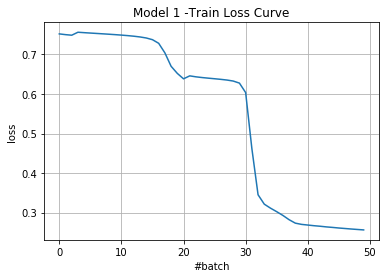

In [8]:
plt.title('Model 1 -Train Loss Curve')
plt.xlabel("#batch")
plt.ylabel("loss")
plt.grid()
plt.plot(range(n_episodes), loss)
plt.show()

改变对P随机初始化时的随机种子，得到其他随机的结果的loss曲线都是下降的，不过收敛的效果不尽相同（因为毕竟随机梯度下降有收敛不稳定的情况存在）  
**注意：如今通过训练得到了P，于是$M=P_1P_1^T$即为所求的度量矩阵！**

### 模型（1）测试
在之前划分好的测试集上用投影矩阵P投影到新特征空间后的KNN分类，看分类准确率如何

In [9]:
K=10
acc = 0
for i in range(test_df.shape[0]):
    dis = []
    xi = test_df.values[i,1:]
    yi = test_df.values[i,0]
    for j in range(train_df.shape[0]):
        xj = train_df.values[j,1:]
        yj = train_df.values[j,0]
        dis.append(Dist(P_1,xi,xj))
    candidates = train_df.values[np.argsort(np.array(dis))[:K], 0].astype(int)
    prediction = np.argmax(np.bincount(candidates))
    if prediction == yi:
        acc += 1
print("测试集上ACC=%F%%"%(acc/test_df.shape[0]))

测试集上ACC=0.816901%


### 结论：
在训练集上运用模型（1）的方法训练好一个线性变换矩阵P后，在即使是没见过的测试集样本上直接用KNN在P变换的新特征空间上表现很不错，ACC高达82%（对比不做线性变换矩阵P直接在原特征空间中用欧氏距离分类只有70%的ACC），其实后续还可以增加动态适配学习率+SGD_momentum等等策略进一步调参，结果还能更好，达到这篇工作论文中的90+的结果。总之：**学到的变换矩阵P可以将数据从原特征空间投影到低维的新特征空间中，并且在新空间中相同类别之间的距离更接近。**
### 为了验证以上结论，我们进行以下定性实验！
设置参数d=2，也即投影到2维，便于可视化。  
注意：论文中有提到这个NCA方法除了度量学习另外一大应用便是特征降维，在这里找到了对应！

In [10]:
#参数
n_episodes = 50
batch_size = 35
d = 2
learning_rate = 0.0001
# Train
P,loss = SGD(train_df, n_episodes, batch_size, d, learning_rate)

Episode 0: loss=0.460261
Episode 1: loss=0.459402
Episode 2: loss=0.458665
Episode 3: loss=0.457939
Episode 4: loss=0.457145
Episode 5: loss=0.456191
Episode 6: loss=0.454940
Episode 7: loss=0.453139
Episode 8: loss=0.450297
Episode 9: loss=0.445461
Episode 10: loss=0.437211
Episode 11: loss=0.425650
Episode 12: loss=0.414633
Episode 13: loss=0.404262
Episode 14: loss=0.385999
Episode 15: loss=0.334512
Episode 16: loss=0.324658
Episode 17: loss=0.319711
Episode 18: loss=0.309412
Episode 19: loss=0.363165
Episode 20: loss=0.387878
Episode 21: loss=0.349541
Episode 22: loss=0.337823
Episode 23: loss=0.328953
Episode 24: loss=0.317843
Episode 25: loss=0.306280
Episode 26: loss=0.298315
Episode 27: loss=0.293811
Episode 28: loss=0.291550
Episode 29: loss=0.289232
Episode 30: loss=0.289726
Episode 31: loss=0.285045
Episode 32: loss=0.285700
Episode 33: loss=0.280656
Episode 34: loss=0.283005
Episode 35: loss=0.275313
Episode 36: loss=0.273483
Episode 37: loss=0.278203
Episode 38: loss=0.280

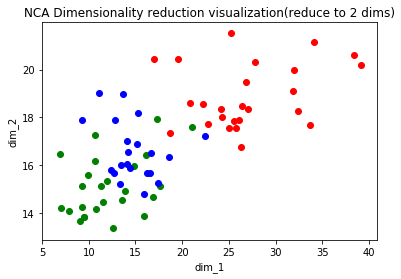

In [11]:
plt.title('NCA Dimensionality reduction visualization(reduce to 2 dims)')
plt.xlabel("dim_1")
plt.ylabel("dim_2")
for i in range(test_df.shape[0]):
    xi = test_df.values[i,1:]
    yi = test_df.values[i,0]
    reduced_xy = np.matmul(P,xi)
    if yi == 1:
        plt.scatter(reduced_xy[0], reduced_xy[1], c='r')
    elif yi == 2:
        plt.scatter(reduced_xy[0], reduced_xy[1], c='g')
    else:
        plt.scatter(reduced_xy[0], reduced_xy[1], c='b')
plt.show()

### 定性实验结论：
可见在新特征空间中，即使只有2维，三类的测试集样本也很好的分开了。当然了我相信再费点功夫进一步调参还能做得更好（比如动态适配学习率等策略）。  
**值得注意的一点是上图中虽然同一类别的样本之间距离接近，但是不同类样本之间似乎不够远离，因而就引出了模型（2），显式地去约束不同类样本之间margin距离！**

--------------------
## 求解模型（2）
根据前面理论分析部分的推导，可以写出优化模型代码

In [12]:
def cal_eta(batch_df,K=3):
    eta = np.zeros([batch_df.shape[0],batch_df.shape[0]])
    for i in range(batch_df.shape[0]):
        dis = []
        xi = batch_df.values[i,1:]
        yi = batch_df.values[i,0]
        for k in range(batch_df.shape[0]):
            xk = batch_df.values[k,1:]
            yk = batch_df.values[k,0]
            dis.append(np.dot(xi-xk, xi-xk))
        count=0
        for arg in np.argsort(np.array(dis)):
            if batch_df.values[arg,0] == yi:
                count += 1
                eta[i,arg] = 1
                if count >= K:
                    break
    return eta

def cost_func(batch_df,P,i,xi,yi,eta,c=0.3):
    sum_j = 0
    for j in range(batch_df.shape[0]):
        if eta[i,j] == 1:
            xj = batch_df.values[j,1:]
            sum_j += Dist(P,xi,xj)
    sum_jl = 0
    for j in range(batch_df.shape[0]):
        for l in range(batch_df.shape[0]):
            if eta[i,j] == 1 and batch_df.values[l,0] != yi:
                xj = batch_df.values[j,1:]
                xl = batch_df.values[l,1:]
                sum_jl += max(1 + Dist(P,xi,xj) - Dist(P,xi,xl), 0)
    return sum_j + c * sum_jl

def cal_gradient_2(batch_df,P,i,xi,yi,eta,c=0.3):  
    sum_j = 0
    for j in range(batch_df.shape[0]):
        if eta[i,j] == 1:
            xj = batch_df.values[j,1:]
            sum_j += np.outer(xi-xj,xi-xj)
    sum_jl = 0
    for j in range(batch_df.shape[0]):
        for l in range(batch_df.shape[0]):
            if eta[i,j] == 1 and batch_df.values[l,0] != yi:
                xj = batch_df.values[j,1:]
                xl = batch_df.values[l,1:]
                if Dist(P,xi,xj) > Dist(P,xi,xl) - 1:
                    sum_jl += (np.outer(xi-xj,xi-xj) - np.outer(xi-xl,xi-xl))
    return 2*np.matmul(P, sum_j + c * sum_jl)
    
def SGD_2(train_df, n_episodes, batch_size, d, learning_rate, c, K):
    loss=[]
    np.random.seed(1) #random_seed
    P = np.random.rand(d, train_df.shape[1]-1) / (train_df.shape[1]-1)
    for episode in range(n_episodes):
        batch_loss = []
        gredient = 0
        # sample a batch
        batch_df = train_df.sample(frac=batch_size/train_df.shape[0], random_state=0)
        eta = cal_eta(batch_df,K)
        for i in range(batch_size):
            x = batch_df.values[i,1:]
            y = batch_df.values[i,0]
            batch_loss.append(cost_func(batch_df,P,i,x,y,eta,c)) 
            gredient += cal_gradient_2(batch_df,P,i,x,y,eta,c)
        P = P - learning_rate * gredient
        print("Episode %d: loss=%f"%(episode,np.average(batch_loss)))
        loss.append(np.average(batch_loss))
    return P,loss

#### 设置训练参数并开始训练
其中n_episodes，batch_size，d，learning_rate都和模型（1）一样，具体说明见上。新增参数：  
c表示损失函数中对不同类样本过近时的惩罚项的系数（**其实就是受限优化时的拉格朗日乘数**）  
K表示目标最近邻的个数（要优化该点与其K个目标最近邻尽量接近）

In [13]:
#参数
n_episodes = 50
batch_size = 30
d = train_df.shape[1]-1
learning_rate = 1e-7
c = 0.3
K = 3

In [14]:
# Train
P_2,loss = SGD_2(train_df, n_episodes, batch_size, d, learning_rate, c, K)

Episode 0: loss=674.587547
Episode 1: loss=476.218464
Episode 2: loss=337.251641
Episode 3: loss=239.458600
Episode 4: loss=170.589651
Episode 5: loss=121.864400
Episode 6: loss=86.983210
Episode 7: loss=62.324503
Episode 8: loss=45.119835
Episode 9: loss=33.912675
Episode 10: loss=26.761138
Episode 11: loss=23.081084
Episode 12: loss=21.242163
Episode 13: loss=20.399998
Episode 14: loss=19.777703
Episode 15: loss=19.302354
Episode 16: loss=18.981287
Episode 17: loss=18.774855
Episode 18: loss=18.577241
Episode 19: loss=18.383369
Episode 20: loss=18.195083
Episode 21: loss=18.008976
Episode 22: loss=17.825660
Episode 23: loss=17.646294
Episode 24: loss=17.473440
Episode 25: loss=17.303021
Episode 26: loss=17.135172
Episode 27: loss=16.969705
Episode 28: loss=16.805913
Episode 29: loss=16.644486
Episode 30: loss=16.484870
Episode 31: loss=16.330332
Episode 32: loss=16.179106
Episode 33: loss=16.031532
Episode 34: loss=15.884140
Episode 35: loss=15.739851
Episode 36: loss=15.595739
Episo

#### 绘制模型（2）的训练loss曲线

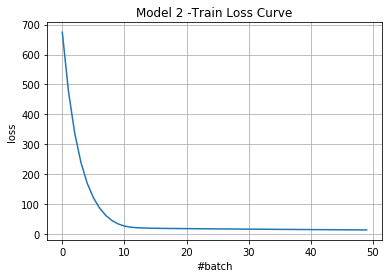

In [15]:
plt.title('Model 2 -Train Loss Curve')
plt.xlabel("#batch")
plt.ylabel("loss")
plt.grid()
plt.plot(range(n_episodes), loss)
plt.show()

比模型（1）的训练loss曲线看起来正常了许多  
**同样的，如今通过模型（2）训练得到了P，于是$M=P_2P_2^T$即为所求的度量矩阵！**

### 模型（2）测试
在之前划分好的测试集上用投影矩阵P投影到新特征空间后的KNN分类，看分类准确率如何

In [16]:
K=10
acc = 0
for i in range(test_df.shape[0]):
    dis = []
    xi = test_df.values[i,1:]
    yi = test_df.values[i,0]
    for j in range(train_df.shape[0]):
        xj = train_df.values[j,1:]
        yj = train_df.values[j,0]
        dis.append(Dist(P_2,xi,xj))
    candidates = train_df.values[np.argsort(np.array(dis))[:K], 0].astype(int)
    prediction = np.argmax(np.bincount(candidates))
    if prediction == yi:
        acc += 1
print("测试集上ACC=%F%%"%(acc/test_df.shape[0]))

测试集上ACC=0.859155%


### 结论：
这里模型（2）的结果和上面模型（1）的结果是可以比的，因为用了相同的训练集、相同的测试集、相同的优化算法、步长、最近邻个数K等等。可见模型（2）的结果要好一点ACC=86%，模型（1）ACC=82%，对比不做线性变换矩阵P直接在原特征空间中用欧氏距离分类的baseline只有ACC=70%.
### 同样做一下模型（2）的定性实验
设置参数d=2，也即投影到2维，便于可视化。  

In [17]:
#参数
n_episodes = 50
batch_size = 35
d = 2
learning_rate = 1e-7
c = 0.3
K = 3
# Train
P,loss = SGD_2(train_df, n_episodes, batch_size, d, learning_rate, c, K)

Episode 0: loss=111.862513
Episode 1: loss=83.584857
Episode 2: loss=62.872471
Episode 3: loss=47.405933
Episode 4: loss=36.126886
Episode 5: loss=27.850782
Episode 6: loss=21.618743
Episode 7: loss=16.965885
Episode 8: loss=13.522303
Episode 9: loss=11.013284
Episode 10: loss=9.275368
Episode 11: loss=8.077870
Episode 12: loss=7.380102
Episode 13: loss=6.915377
Episode 14: loss=6.611914
Episode 15: loss=6.320485
Episode 16: loss=5.975439
Episode 17: loss=5.590524
Episode 18: loss=5.191772
Episode 19: loss=4.806293
Episode 20: loss=4.498865
Episode 21: loss=4.293846
Episode 22: loss=4.139388
Episode 23: loss=4.034826
Episode 24: loss=3.972723
Episode 25: loss=3.931623
Episode 26: loss=3.901525
Episode 27: loss=3.876064
Episode 28: loss=3.856080
Episode 29: loss=3.842422
Episode 30: loss=3.830219
Episode 31: loss=3.819113
Episode 32: loss=3.809583
Episode 33: loss=3.801398
Episode 34: loss=3.793603
Episode 35: loss=3.786796
Episode 36: loss=3.780447
Episode 37: loss=3.774252
Episode 38:

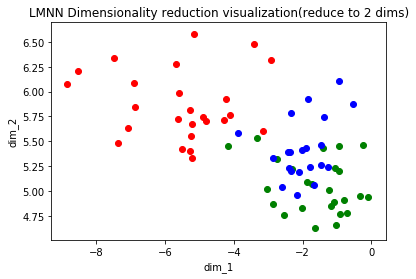

In [18]:
plt.title('LMNN Dimensionality reduction visualization(reduce to 2 dims)')
plt.xlabel("dim_1")
plt.ylabel("dim_2")
for i in range(test_df.shape[0]):
    xi = test_df.values[i,1:]
    yi = test_df.values[i,0]
    reduced_xy = np.matmul(P,xi)
    if yi == 1:
        plt.scatter(reduced_xy[0], reduced_xy[1], c='r')
    elif yi == 2:
        plt.scatter(reduced_xy[0], reduced_xy[1], c='g')
    else:
        plt.scatter(reduced_xy[0], reduced_xy[1], c='b')
plt.show()

### 总结：
本次作业阅读了两篇度量学习的经典论文[1,2]，并分别针对这两篇论文的算法进行了实现，简言之都是学习一个映射矩阵P，将样本从原特征空间投影到新的特征空间中更好的分类，而$M=PP^T$即为所求的半正定度量矩阵。通过定量实验（验证集ACC表现很好高达82%和86%）和定性实验（在新特征空间中，即使只有2维，三类的测试集样本也很好的分开），验证了模型（1）和模型（2）的有效性，以及简单SGD就能胜任机器学习任务。  
当然后续还有可以进一步提高的地方，比如我这里只用了单一学习率，没有动态调整学习率，也没有用新学的一些加速与适应的优化算法。

[1] Jacob Goldberger, Sam Roweis, Geoff Hinton, Ruslan Salakhutdinov. "Neighbourhood components analysis." NIPS 2005.  
[2] Kilian Q. Weinberger, John Blitzer and Lawrence K. Saul. "Distance metric learning for large margin nearest neighbor classification." NIPS 2006.